# Anomaly Detection in Muscle Movement


In [1]:
%matplotlib inline

In [6]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lsanomaly
from math import sqrt

#### Importing indices and values of all tests to data frames


In [7]:
mov_data = pd.read_csv("C:/Users/gaffar/Downloads/sept17/movement-master/movement-master/test_data/output.csv",usecols=[1])
mov_data2 = pd.read_csv("C:/Users/gaffar/Downloads/sept17/movement-master/movement-master/test_data/output.csv",usecols=[0])
df1 = pd.DataFrame(mov_data)
df2 = pd.DataFrame(mov_data2)

###  Plot of data values present in all test csv files


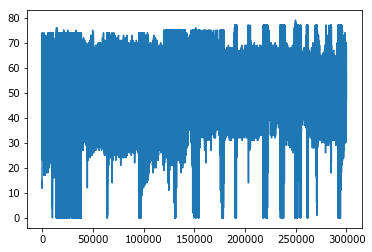

In [9]:
plt.plot(df1)

### Plot of Moving Averages of the Total Data 

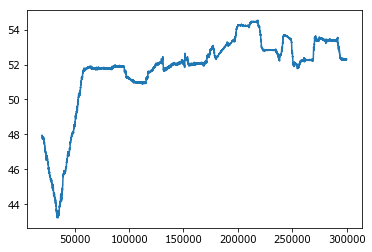

In [10]:
plt.plot(df1.rolling(window=20000).mean())


We can see that by using Moving Averages, it would be difficult to proceed due in inefficiency and non contextuality in graph data.

We calculate Residue and plot it .

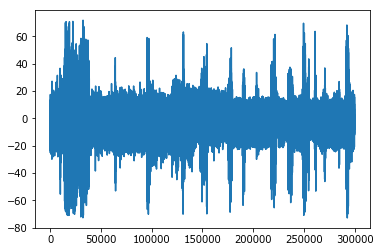

In [11]:
mov_avg1 = (df1.rolling(window=100).mean())

#Calculating Residual
res = df1 - mov_avg1

#Plotting Residual
plt.plot(res)


We see improvement because it is easier to understand the data in our graph and the deviance indicates anomalistic behavior within our data.

After looking at the overall data, we implement an algorithm to detect anomalies in test1 dataset
This algorithm can also be used on the overall data stored in output.csv

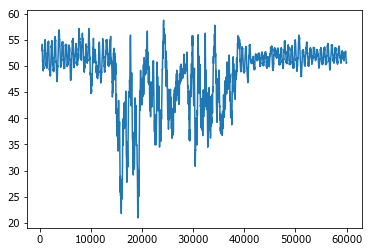

In [12]:
data1= pd.read_csv("C:/Users/gaffar/Downloads/sept17/movement-master/movement-master/test_data/test1.csv",usecols=[0])
dff1 = pd.DataFrame(data1)
plt.plot(dff1.rolling(window=500).mean())
mov_avg11 = (dff1.rolling(window=100).mean())
ress1 = dff1 - mov_avg11

The graph above indicates moving averages and even though the anomalies are evident, the training data / normal data is not clearly defined.


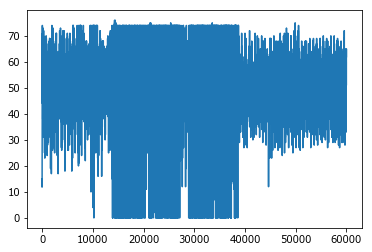

In [13]:
plt.plot(dff1)

The above graph indicates the actual data present in the test1 dataset.

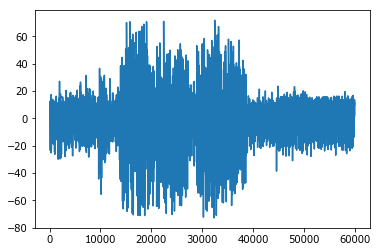

In [14]:
plt.plot(ress1)

The above graph indicates the residue got after subtracting moving averages from the original data. The normal data in the graph is clearly defined and we can begin detecting anomalies from this graph.

In [15]:

#the residual has a lot of NaN Values, eliminating all of them
ress1 = ress1.fillna(0)

#assigning index values to train normal data

cd1 = np.arange(35000,59991)
cd = np.arange(0,13500)
c = np.concatenate((cd,cd1))

### Using the package 'lsanomaly', we now begin training and testing the residual values which will ultimately provide us with the range of time for which the anomalies were effective.  

In [16]:
X_train = ress1.iloc[c.tolist()]
X_test = ress1.iloc[:]
anomalymodel = lsanomaly.LSAnomaly()

#indexing the index
X_train.index = range(0,38491)

anomalymodel.fit(X_train.values)

ts = anomalymodel.predict(X_test.values)

The 'ts' variable has two values : 0 and 'anomaly' . In order to further our operations, we need to convert 'anomaly' to a numeral value and also convert the 'ts' variable to a numpy array for future operations.

In [17]:

for i in range(0,len(ts)) :
    if (ts[i]==0):
        ts[i]=1

for i in range(0,len(ts)) :
    if (ts[i]=='anomaly'):
        ts[i]=0


np.set_printoptions(threshold='nan')

ts=np.array(ts)

ts = ts.astype(np.int)

[None, None]

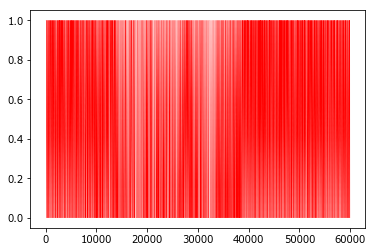

In [18]:
# See where the algorithm has detected anomalies through difference in color
lines = plt.plot(ts)
plt.setp(lines, color='r', linewidth=0.09)


The white portion in the graph indicates the position where anomalies are present.

The graph is unclear and to get a better idea, we define another variable to get a clearer graph.

[None, None]

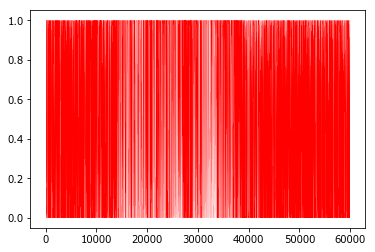

In [19]:
dd = anomalymodel.predict_proba(X_test)

#honestly this graph looks better
line = plt.plot(dd[:,1])
plt.setp(line, color='r', linewidth=0.07)


This graph better indicates the aomalies present and we will use the variable which was used to plot this graph henceforth to find the time series to when the anomalies were present.

In [29]:
idx=np.where(dd[:,0]==0)

dg = np.concatenate(idx).tolist()
dg1 = np.array(dg, dtype=int)

The 'dg1' variable has the indices of the time series for when the anomalies were most effective. The length of the variable is quite large and the data is very unstructured to be used. We thus use a Clustering algorithm to find where the anomalies were most dense and weed out the 'noisy' data in the process.

In [21]:
#algorithm for clustering values

def stat(lst):
    """Calculate mean and std deviation from the input list."""
    n = float(len(lst))
    mean = sum(lst) / n
    stdev = sqrt((sum(x*x for x in lst) / n) - (mean * mean))
    return mean, stdev

def parse(lst, n):
    cluster = []
    for i in lst:
        if len(cluster) <= 1:    # the first two values are going directly in
            cluster.append(i)
            continue

        mean,stdev = stat(cluster)
        if abs(mean - i) > n * stdev:    # check the "distance"
            yield cluster
            cluster[:] = []    # reset cluster to the empty list

        cluster.append(i)
    yield cluster           # yield the last cluster


### Finally, we calculate the time series indices for when the anomalies were most effective by using clusters at least 40 units long representing continual anomaly.

In [34]:

#printing those starts and endings where anomalies where detected.

for cluster in parse(dg, 2):

    if len(cluster)> 40:
        print(cluster[0],cluster[len(cluster)-1])



10969 17573
18368 18468
18600 18776
19314 19450
20350 20391
21185 21249
21806 21922
22337 22492
22877 22997
25019 25257
29225 29352
31144 31224
31544 31628
31948 32051
32956 33030
33114 33180
35017 35386


### We can see that our algorithm has found many anomalies in the range from 11k to 35k units of time. It did encounter anomalies elsewhere but those were dismissed as noise and the effective 'noise-cancellation' was made possible by clustering our data and only taking those clusters that were more than 40 units in length. This program is capable of detecting anomalies in other unsupervised univariate time series and we hope it does a satisfactory job in it.